In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

# Crime Data Import

In [2]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [3]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [4]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime")).where(col('Year')!=2018)

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF = crimeDF.select('Category','Year','Month','DayOfMonth','Hour','Minute','District','Latitude',\
                        'Longitude')
crimeDF.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- District: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

# Crime with effect on Category

In [6]:
categories = [u'ARSON', u'ASSAULT', u'BAD CHECKS', u'BRIBERY', u'BURGLARY', u'DISORDERLY CONDUCT',\
              u'DRIVING UNDER THE INFLUENCE', u'DRUG/NARCOTIC', u'DRUNKENNESS', u'EMBEZZLEMENT', \
              u'EXTORTION', u'FAMILY OFFENSES', u'FORGERY/COUNTERFEITING', u'FRAUD', u'GAMBLING', \
              u'KIDNAPPING', u'LARCENY/THEFT', u'LIQUOR LAWS', u'LOITERING', u'MISSING PERSON', \
              u'NON-CRIMINAL', u'OTHER OFFENSES', u'PORNOGRAPHY/OBSCENE MAT', u'PROSTITUTION', \
              u'RECOVERED VEHICLE', u'ROBBERY', u'RUNAWAY', u'SECONDARY CODES', \
              u'SEX OFFENSES, FORCIBLE', u'SEX OFFENSES, NON FORCIBLE', u'STOLEN PROPERTY', \
              u'SUICIDE', u'SUSPICIOUS OCC', u'TREA', u'TRESPASS', u'VANDALISM', u'VEHICLE THEFT',\
              u'WARRANTS', u'WEAPON LAWS']
categoryCount = len(categories)

In [7]:
count = crimeDF.groupBy('Category').count().orderBy('count')\
.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES']))
total = crimeDF.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES'])).count()

In [8]:
total

1631488

In [9]:
categoryCount

39

In [10]:
categories = count.rdd.map(lambda x: x[0]).collect()
countlist = count.rdd.map(lambda x: x[1]).collect()
categoryCount = len(countlist)
n_categories = np.arange(categoryCount)
n_count = len(categories)
cmax = countlist[-1]
ratiolist = np.arange(categoryCount,dtype=float)
for c in range(categoryCount):
    ratiolist[c] = "{0:.2f}".format(countlist[c]/float(total)*100.,2)

In [11]:
# filtering
ratiolist = ratiolist[-16:]
categories = categories[-16:]
countlist = countlist[-16:]
categoryCount = len(countlist)
n_categories = np.arange(categoryCount)
colors = np.append(np.repeat(['grey'],10),np.repeat(['red'],categoryCount-10))
sizes = np.append(np.repeat([8],10),np.repeat([12],categoryCount-10))
color2 = np.append(np.repeat(['white'],10),np.repeat(['black'],categoryCount-10))

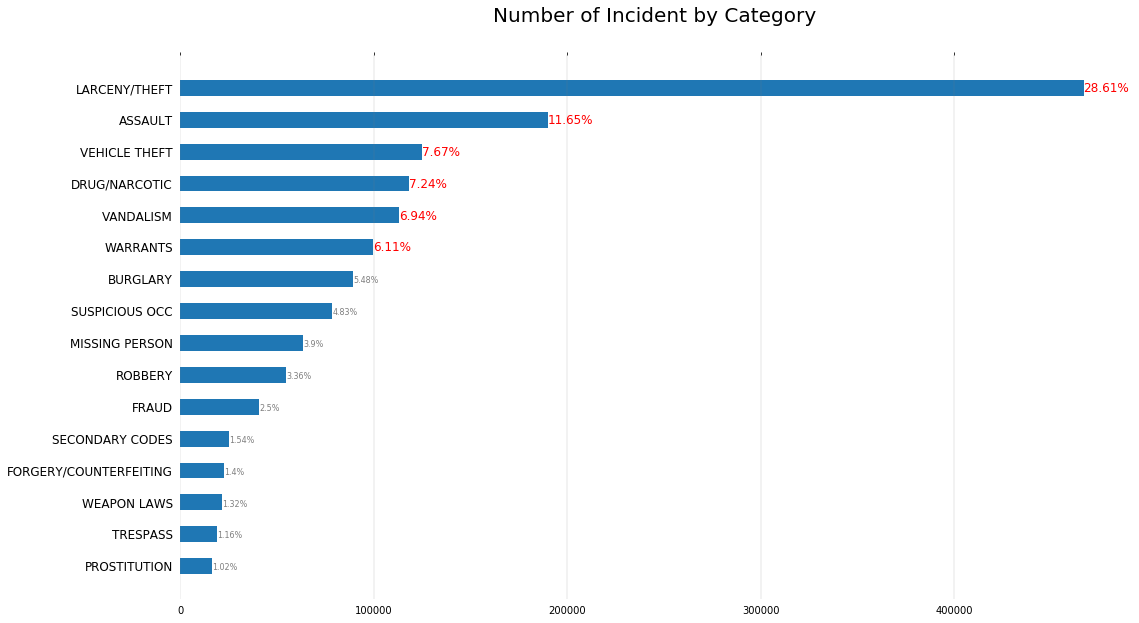

In [12]:
fig = plt.figure(figsize=(17,10))

ax = fig.add_subplot(111)
ax.set_yticklabels(categories, size="12")
ax.set_yticks(n_categories)
# ax.set_ylabel("Crime Category",size="20")
# ax.set_xlabel('Number of Incident',size="20")
ax.set_title('Number of Incident by Category', size=20, y=1.05)
ax.grid(color='grey', axis='x', linewidth=.2)
plt.tick_params(top='on', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
plt.box(False)
for i in range(len(n_categories)):
    ax.text(countlist[i]+.5, n_categories[i] - .125, str("{}%".format(ratiolist[i])), color=colors[i],size=sizes[i])

bar = ax.barh(n_categories,countlist,height=0.5)
# for b in range(len(bar)):
#     bar[b].set_color(colors[b])

# Crime with effect on Month and Year

In [13]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [14]:
data = crimeDF.where((col('Year').isNotNull())&(col('Month').isNotNull()))\
.groupBy('Year','Month').count().orderBy('Year','Month')

In [15]:
yearlist = np.asarray([2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017])
xlen = len(yearlist)
monthlist = np.asarray(['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December'])
ylen = len(monthlist)
count = data.rdd.map(lambda x:x[2]).collect()
clen = len(count)

In [16]:
img = np.asarray(count,dtype=float)
#calculation of index between 0 and 1
maxc = np.amax(img)
minc = np.amin(img)
flow = maxc - minc
# np.subtract(img,np.repeat(np.amax(img),clen))
# np.divide(img,np.repeat(np.amax(img)-np.amin(img),clen))
for i in range(len(img)):
    img[i] = img[i]/maxc

img = img.reshape(ylen,xlen)

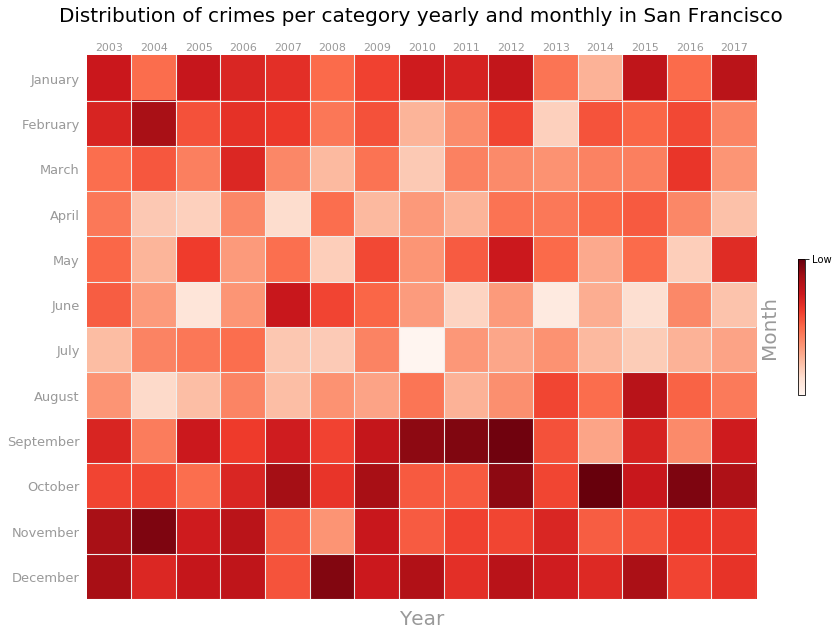

In [17]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(15,10),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img,  aspect='auto', cmap=cm.Reds)

# x-axis labels
for x, y, s in zip(np.arange(-.30, xlen, 1), np.repeat(-.6, xlen), [str(x) for x in yearlist]):
    plt.text(x, y, s, color='#999999', size='11')
# y-axis labels
for x, y, s in zip(np.repeat(-.65, ylen), np.arange(.125, ylen, 1), [str(x) for x in monthlist]):
    plt.text(x, y, s, color='#999999', size='13', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category yearly and monthly in San Francisco", size=20, y=1.05)
plt.xlabel("Year", color='#999999', size="20")
plt.ylabel("Month", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()

# Crime with effect on Day and Hour

In [18]:
data2 = crimeDF.where((col('Hour').isNotNull())&(col('DayOfMonth').isNotNull()))\
.groupBy('DayOfMonth','Hour').count().orderBy('Hour','DayOfMonth')

In [19]:
week = np.arange(7)

daylist = np.arange(31)
xlen = len(daylist)
hourlist = np.arange(24)
ylen = len(hourlist)
count = data2.rdd.map(lambda x:x[2]).collect()
clen = len(count)

In [20]:
img2 = np.asarray(count,dtype=float)
#calculation of index between 0 and 1
maxc = np.amax(img2)
minc = np.amin(img2)
flow = maxc - minc
# np.subtract(img,np.repeat(np.amax(img),clen))
# np.divide(img,np.repeat(np.amax(img)-np.amin(img),clen))
for i in range(len(img2)):
    img2[i] = img2[i]/maxc

img2 = img2.reshape(ylen,xlen)

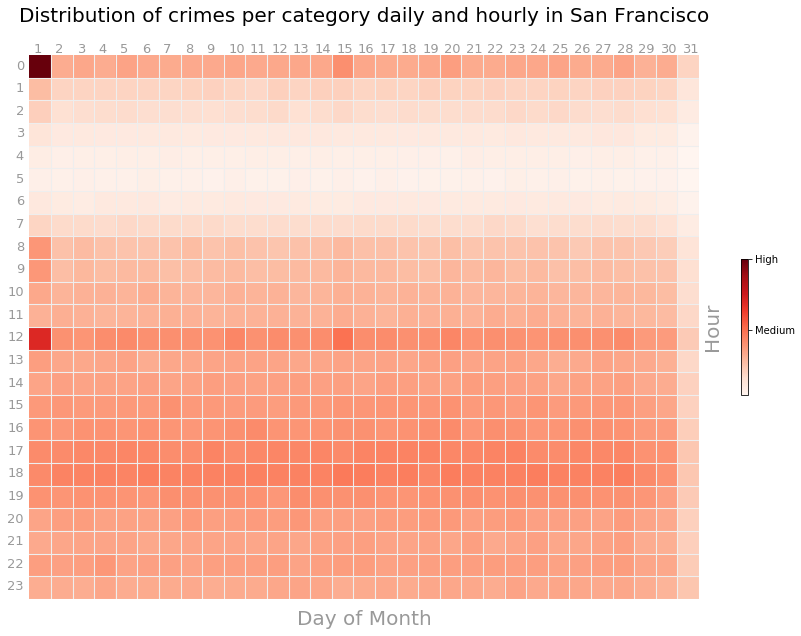

In [21]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(15,10),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img2,  aspect='auto', cmap=cm.Reds)

# x-axis labels
for x, y, s in zip(np.arange(-.30, xlen, 1), np.repeat(-.6, xlen), [str(x+1) for x in daylist]):
    plt.text(x, y, s, color='#999999', size='13')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, ylen), np.arange(.125, ylen, 1), [str(x) for x in hourlist]):
    plt.text(x, y, s, color='#999999', size='13', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category daily and hourly in San Francisco", size=20, y=1.05)
plt.xlabel("Day of Month", color='#999999', size="20")
plt.ylabel("Hour", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Medium', 'High', 'High'])

plt.show()

# Crime with effect on District

In [22]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

shp = fiona.open('sffind_neighborhoods.shp')

# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Read SF neighborhood data into Basemap


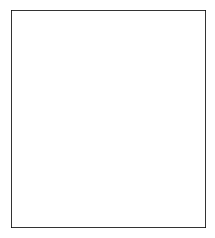

In [23]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'sffind_neighborhoods',
    'SF',
    color='none',
    zorder=2)

print "Read SF neighborhood data into Basemap"

In [24]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 1000000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))
# df_map.count()

In [25]:
def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    longitude = dat.select('Longitude').rdd.map(lambda x: x[0]).collect()
    latitude = dat.select('Latitude').rdd.map(lambda x: x[0]).collect()
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(longitude,latitude)])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

In [26]:
crime_2017 = crimeDF.where(col('Year').isin(2017))

districts = crimeDF.groupBy('District').agg({'*':'count'}).select('District')\
                  .where(col('District').isNotNull()).rdd.map(lambda x : x[0]).collect()

district_list = [1] * len(districts)
district_pts_list = [1] * len(districts)
for i in range(len(districts)):
    district_list[i] = crime_2017.where(col('District')==districts[i])
    district_pts_list[i] = makePoints(district_list[i])

In [27]:
pts_list = district_pts_list
pts_color = ['red','blue','yellow','magenta','cyan','green','orange','gold','purple','lime','salmon','tomato']
pts_label = districts
pts_lw = [.25] * len(districts)

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in pts_list[pts_index]],
    [geom.y for geom in pts_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)

<Figure size 432x288 with 0 Axes>

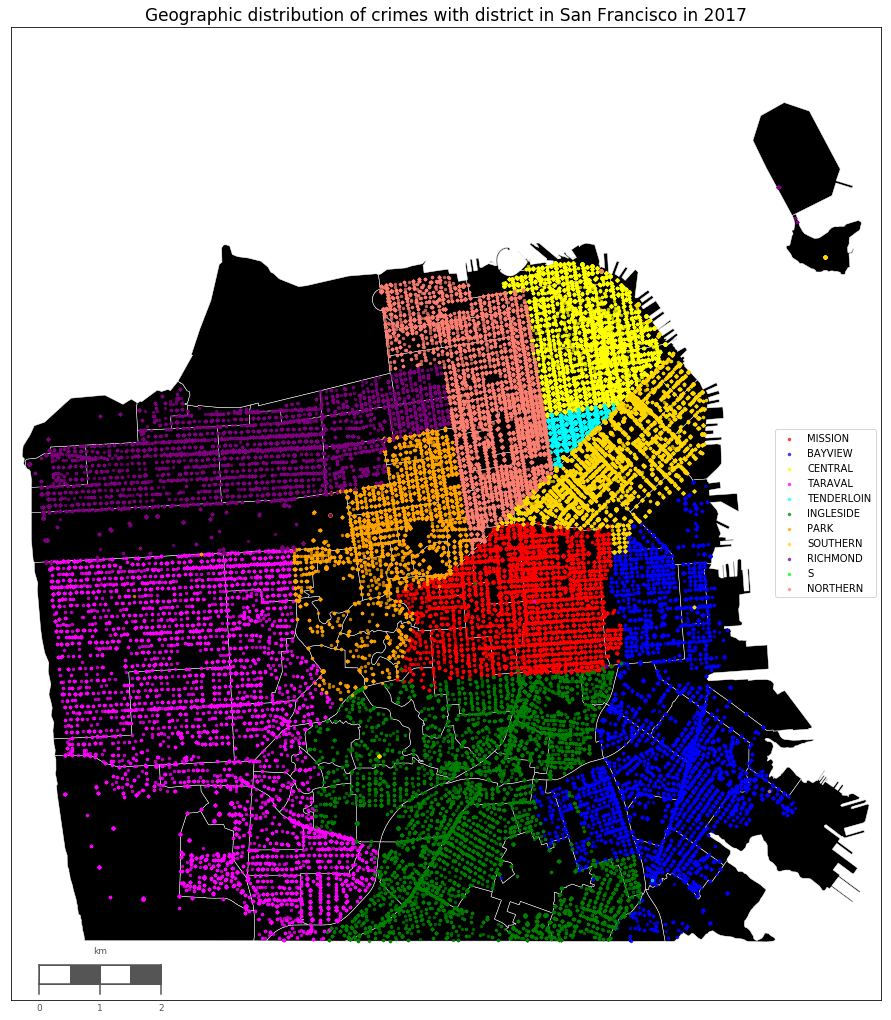

In [28]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

for i in range(len(pts_list)):
    bmScatter(i)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of crimes with district in San Francisco in 2017", size=17)
fig.set_size_inches(15,15)
plt.show()

# Crime with effect on Main Crimes

In [29]:
main_crimes = \
[u'WARRANTS',
 u'VANDALISM',
 u'DRUG/NARCOTIC',
 u'VEHICLE THEFT',
 u'ASSAULT',
 u'LARCENY/THEFT']
main_crimes = main_crimes[::-1]
main_crimes

[u'LARCENY/THEFT',
 u'ASSAULT',
 u'VEHICLE THEFT',
 u'DRUG/NARCOTIC',
 u'VANDALISM',
 u'WARRANTS']

In [30]:
main_crime_2017 = crimeDF.where(col('Year').isin(2017)).where(col('Category').isin(main_crimes))

main_crime_2017_list = [1] * len(main_crimes)
main_crime_2017_pts_list = [1] * len(main_crimes)
for i in range(len(main_crimes)):
    main_crime_2017_list[i] = main_crime_2017.where(col('Category')==main_crimes[i])
    main_crime_2017_pts_list[i] = makePoints(main_crime_2017_list[i])

main_crime_2017_pts = makePoints(main_crime_2017)

In [31]:
pts_color = ['cyan', 'magenta', 'yellow', 'red', 'green', 'orange'] #DarkGoldenRod Chocolate Gold Brown 
pts_label = main_crimes
pts_lw = [.25,.3,.35,.4,.45,.5]
crimes_pts_list = main_crime_2017_pts_list

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in crimes_pts_list[pts_index]],
    [geom.y for geom in crimes_pts_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)

<Figure size 432x288 with 0 Axes>

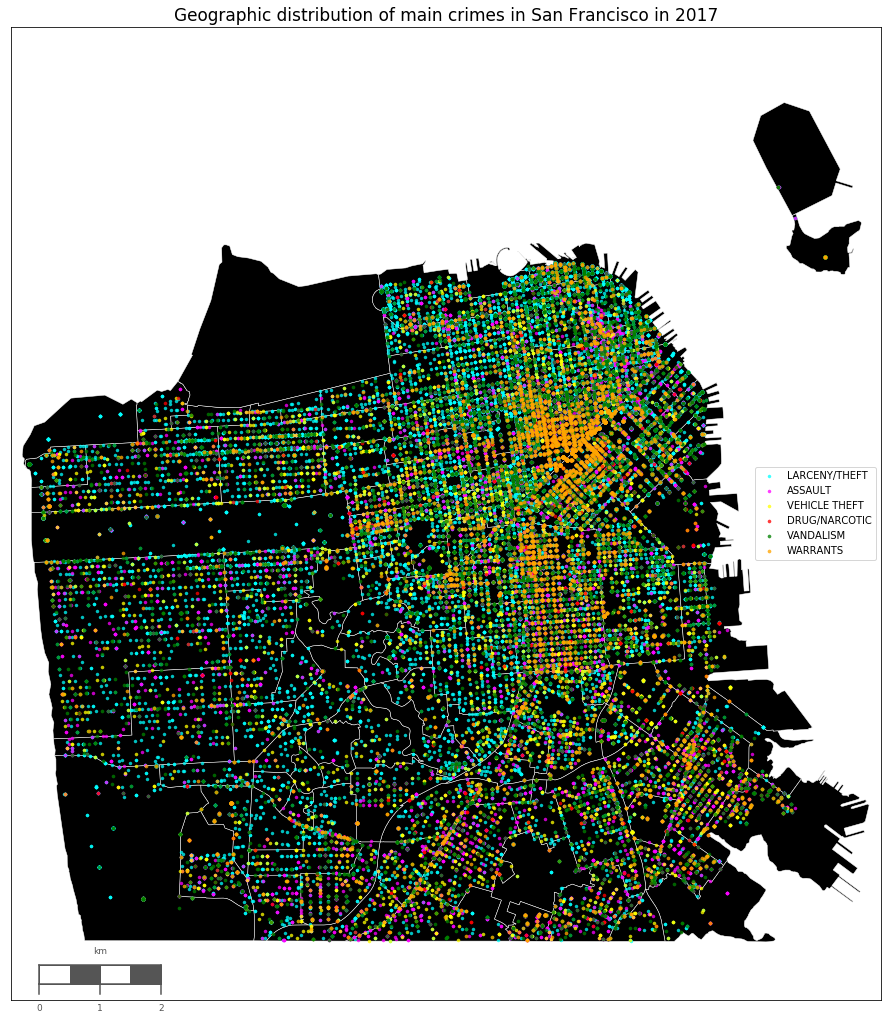

In [32]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

for i in range(len(crimes_pts_list)):
    bmScatter(i)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of main crimes in San Francisco in 2017", size=17)
fig.set_size_inches(15,15)
plt.show()

# Crime Density

In [33]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, main_crime_2017_pts))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km
106,"POLYGON ((9430.7667623753 10737.68012050866, 8...",Russian Hill,9.472392e+05,0.947239,"Poly((9430.77, 10737.7) ...)",1384,0.001461,1461.088234
99,"POLYGON ((8365.098415548302 9956.497120805427,...",Cathedral Hill,4.912679e+05,0.491268,"Poly((8365.1, 9956.5) ...)",1364,0.002776,2776.489396
73,"POLYGON ((8180.830114272736 958.946107019956, ...",Sunnydale,3.756807e+05,0.375681,"Poly((8180.83, 958.946) ...)",331,0.000881,881.067275
89,"POLYGON ((7539.991345375878 1867.318677264866,...",Excelsior,1.674291e+06,1.674291,"Poly((7539.99, 1867.32) ...)",654,0.000391,390.613092
79,"POLYGON ((6425.1602796718 1549.772660209338, 6...",Cayuga,7.414955e+05,0.741496,"Poly((6425.16, 1549.77) ...)",348,0.000469,469.321765


In [34]:
import jenkspy

# Density boundaries
break_density = jenkspy.jenks_breaks(df_map[df_map['density_km'].notnull()].density_km.values,nb_class=10)

# Count
break_count = [1] * 10
for i in range(len(break_density)):
    if i > 0:
        ranges = df_map['density_km'].between(break_density[i-1],break_density[i])
        break_count[i-1] = df_map[ranges]['density_km'].count()

# Index for each categories
break_index = [-1] * (len(df_map)-1)
for i in range(len(df_map)-1):
    for j in range(len(break_density)):
        if j > 0:
            density = df_map['density_km'].array[i]
            check = (density > break_density[j-1]) & (density < break_density[j])
            if check: 
                break_index[i] = j-1
            
        
break_density = break_density[1:len(break_density)]

In [35]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': break_index}, index=df_map[df_map['density_km'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["<= %0.1f crimes / km$^2$" % b for b in break_density]
jenks_labels.insert(0, 'No crimes')

<Figure size 432x288 with 0 Axes>

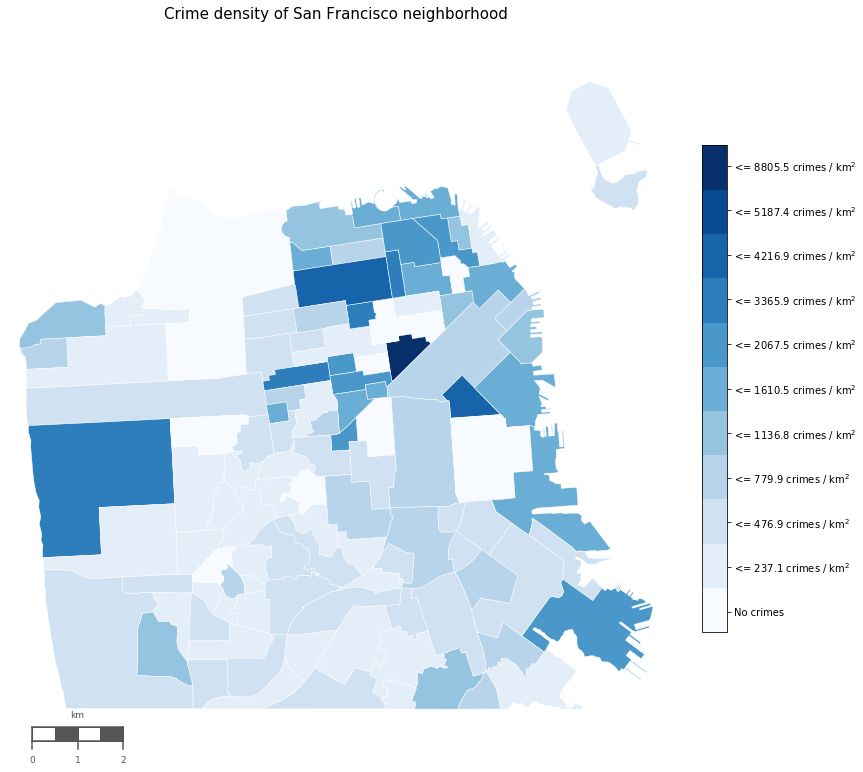

In [36]:
from matplotlib.colors import Normalize, LinearSegmentedColormap 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.tight_layout()
plt.title("Crime density of San Francisco neighborhood", size=15)
fig.set_size_inches(15, 15)
plt.show()

# Weather data import

In [37]:
weatherDF = spark.read.csv('s3a://davidsx/weather', header=True)

In [38]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime")).where(col('Year')!=2018)

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF = crimeDF.select('Category','Year','Month','DayOfMonth','Hour','Minute','District','Latitude',\
                        'Longitude')
crimeDF.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- District: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [39]:
from pyspark.sql.functions import to_timestamp, concat_ws, regexp_replace

weatherDF = weatherDF.withColumn('Datetime_str',regexp_replace(col("DATE"), "T", " "))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'yyyy-MM-dd HH:mm:ss').cast(TimestampType()))\


weatherDF = weatherDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

weatherDF = weatherDF.withColumn("Type",col("REPORT_TYPE2"))

weatherDF = weatherDF.drop('DATE','Datetime_str','REPORT_TYPE2')

In [40]:
wdDF = weatherDF.where(col('Type').like('SOD%'))
wdDF = wdDF.select(  \
 'Type',
 'Datetime',
 'Year',
 'Month',
 'DayOfMonth',
 'Hour',
 'Minute',
 'DailyAverageDryBulbTemperature',
 'DailyPrecipitation').where(col('Year')!=2019)
wdDF = wdDF.withColumn('Temperature_str',col('DailyAverageDryBulbTemperature')).drop('DailyAverageDryBulbTemperature')
wdDF = wdDF.withColumn('Precipitation_str',col('DailyPrecipitation')).drop('DailyPrecipitation')
# weatherDF = weatherDF.withColumn('Precipitation_str',col('Precipitation')).drop('Precipitation')
wdDF = wdDF\
.withColumn("Precipitation", when(col("Precipitation_str").endswith('s'), \
                                  expr("substring(Precipitation_str, 1, length(Precipitation_str)-1)")\
                                  .cast(DoubleType()))
            .otherwise(col("Precipitation_str").cast(DoubleType())))
wdDF = wdDF.withColumn("Temperature", col('Temperature_str').cast(DoubleType()))

In [41]:
import calmap

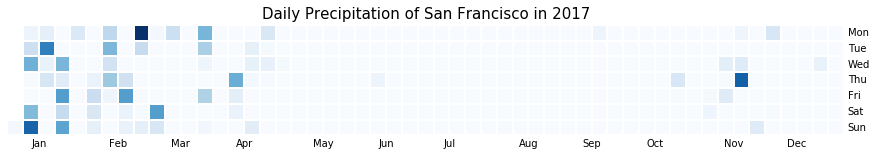

In [42]:
wdDF_2017 = wdDF.where(col('Year')==2017)
daysOf2017 = pd.date_range('1/1/2017',periods=365, freq='D')
rainy_days = wdDF_2017.select('Precipitation').rdd.map(lambda x: x[0]).collect()
rain_series = pd.Series(rainy_days, index=daysOf2017, dtype=float)

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.set_title('Daily Precipitation of San Francisco in 2017', size=15)
calmap.yearplot(rain_series, ax=ax ,year=2017, cmap='Blues')

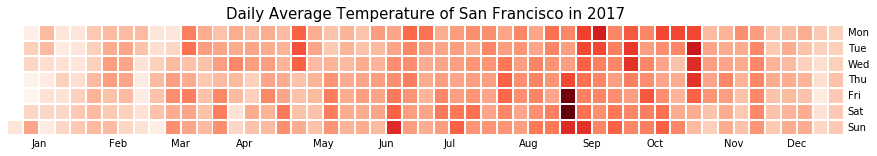

In [43]:
wdDF_2017 = wdDF.where(col('Year')==2017)
daysOf2017 = pd.date_range('1/1/2017',periods=365, freq='D')
temp_days = wdDF_2017.select('Temperature').rdd.map(lambda x: x[0]).collect()
temp_series = pd.Series(temp_days, index=daysOf2017, dtype=float)

fig, ax = plt.subplots(1, 1, figsize = (15, 10))
ax.set_title('Daily Average Temperature of San Francisco in 2017', size=15)
calmap.yearplot(temp_series, ax=ax ,year=2017)

# Create joined DataFrame on crime and weather data

In [44]:
wdDF.cache()
sqlContext.registerDataFrameAsTable(wdDF, 'wd')

In [45]:
joinDF = sqlContext.sql(
"select df.Category, df.Year, df.Month, df.DayOfMonth, df.Hour, df.Minute, \
        df.Longitude, df.Latitude, wd.Temperature, wd.Precipitation " + 
"from df left join wd " +
"where df.Year = wd.Year and df.Month = wd.Month and df.DayOfMonth = wd.DayOfMonth")\
.where((col('Longitude').isNotNull())&(col('Latitude').isNotNull())&\
       (col('Temperature').isNotNull())&(col('Precipitation').isNotNull()))

In [46]:
count = crimeDF.groupBy('Category').count().orderBy('count')\
.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES']))
total = crimeDF.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES'])).count()

# Crime with effect on Precipitation

In [47]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [48]:
data_p = joinDF.orderBy('Precipitation').groupBy('Precipitation').count()\
.where(col('Precipitation').isNotNull())\
.where(col('Precipitation').between(0.01,0.70))\

In [49]:
precipitation = data_p.rdd.map(lambda x: x[0]).collect()
precipitation = list(precipitation)
xlen = len(precipitation)
ylen = 1
count = data_p.rdd.map(lambda x:x[1]).collect()
clen = len(count)
data2d = data_p.collect()

In [50]:
img_p = np.zeros(xlen, dtype=float).reshape(1,xlen)
#calculation of index between 0 and 1
maxc = np.amax(count)
minc = np.amin(count)
flow = maxc - minc

for row in data2d:
    prep = row[0]
    value = row[1]
    img_p[0][precipitation.index(prep)] = value/float(maxc)

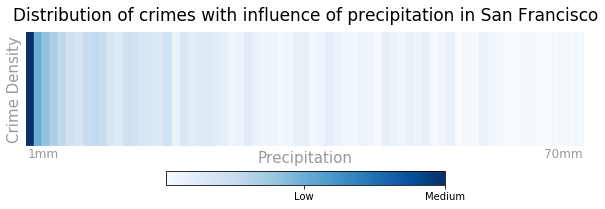

In [51]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(10,3),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=0.2)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_p,  aspect='auto', cmap=cm.Blues)

# plt.text(-15, 0, 'Crime Density', color='#999999',  size='15')
plt.text(-.30, .6, '1mm', color='#999999', size='12')
plt.text(xlen-5.5, .6, '70mm', color='#999999', size='12')
# y-axis labels
plt.title("Distribution of crimes with influence of precipitation in San Francisco", size=17, y=1.05)
plt.xlabel("Precipitation", color='#999999', size="15")
plt.ylabel("Crime Density", color='#999999', size="15")

ax.yaxis.set_label_position("left")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.5, orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

plt.show()

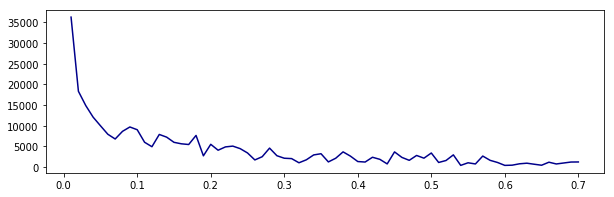

In [52]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)

ax.plot(precipitation,count, color='darkblue')

# Crime with effect on Temperature

In [53]:
data_t = joinDF.orderBy('Temperature').groupBy('Temperature').count()\
.where(col('Temperature').isNotNull())\

In [54]:
temperature = data_t.orderBy('Temperature').groupBy('Temperature').count().rdd.map(lambda x: x[0]).collect()
temperature = list(temperature)
xlen = len(temperature)

In [55]:
ylen = 1
count = data_t.rdd.map(lambda x:x[1]).collect()
count = list(count)
clen = len(count)
data2d = data_t.collect()

In [56]:
img_t = np.zeros(ylen*xlen, dtype=float).reshape(ylen,xlen)
#calculation of index between 0 and 1
maxc = np.amax(count)
minc = np.amin(count)
flow = maxc - minc

for row in data2d:
    temp = row[0]
    value = row[1]
    img_t[0][temperature.index(temp)] = value/float(maxc)

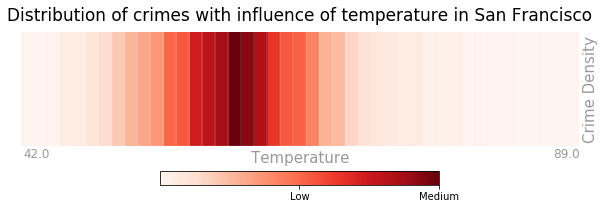

In [57]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(10,3),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=0.2)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_t,  aspect='auto', cmap=cm.Reds)

plt.text(-.30, .6, str(temperature[0]), color='#999999', size='12')
plt.text(xlen-2.5, .6, str(temperature[-1]), color='#999999', size='12')

# title, xlabel, ylabel
plt.title("Distribution of crimes with influence of temperature in San Francisco", size=17, y=1.05)
plt.xlabel("Temperature", color='#999999', size="15")
plt.ylabel("Crime Density", color='#999999', size="15")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.5, orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

plt.show()

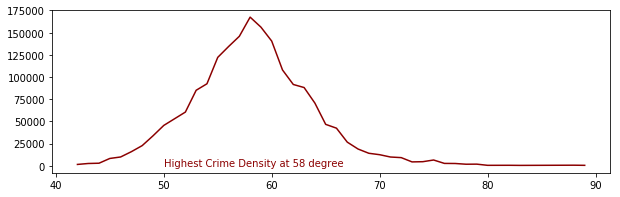

In [58]:
tmax = np.amax(count)
tval = temperature[count.index(tmax)]

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
plt.text(50,70,"Highest Crime Density at {0:.0f} degree".format(tval),color='darkRed')
ax.plot(temperature,count, color='darkred')

# Thank you